In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

%matplotlib inline

In [60]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [61]:
train = pd.read_csv("../data/Avito Demand Prediction/train.csv", parse_dates = ["activation_date"])
test = pd.read_csv("../data/Avito Demand Prediction/test.csv", parse_dates = ["activation_date"])

In [62]:
train.shape

(1503424, 18)

In [63]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 18 columns):
item_id                 1503424 non-null object
user_id                 1503424 non-null object
region                  1503424 non-null object
city                    1503424 non-null object
parent_category_name    1503424 non-null object
category_name           1503424 non-null object
param_1                 1441848 non-null object
param_2                 848882 non-null object
param_3                 640859 non-null object
title                   1503424 non-null object
description             1387148 non-null object
price                   1418062 non-null float64
item_seq_number         1503424 non-null int64
activation_date         1503424 non-null datetime64[ns]
user_type               1503424 non-null object
image                   1390836 non-null object
image_top_1             1390836 non-null float64
deal_probability        1503424 non-null float64
dtypes: datetim

In [64]:
train.head()

item_id       user_id                 region              city  \
0  b912c3c6a6ad  e00f8ff2eaf9   Свердловская область      Екатеринбург   
1  2dac0150717d  39aeb48f0017      Самарская область            Самара   
2  ba83aefab5dc  91e2f88dd6e3     Ростовская область    Ростов-на-Дону   
3  02996f1dd2ea  bf5cccea572d              Татарстан  Набережные Челны   
4  7c90be56d2ab  ef50846afc0b  Волгоградская область         Волгоград   

  parent_category_name               category_name  \
0          Личные вещи  Товары для детей и игрушки   
1      Для дома и дачи           Мебель и интерьер   
2  Бытовая электроника               Аудио и видео   
3          Личные вещи  Товары для детей и игрушки   
4            Транспорт                  Автомобили   

                       param_1     param_2 param_3                  title  \
0    Постельные принадлежности         NaN     NaN  Кокоби(кокон для сна)   
1                       Другое         NaN     NaN      Стойка для Одежды   
2  Видео, DVD и Blu-ray плееры         NaN     NaN         Philips bluray   
3         Автомобильные кресла         NaN     NaN             Автокресло   
4                   С пробегом  ВАЗ (LADA)    2110         ВАЗ 2110, 2003   

                                         description    price  \
0  Кокон для сна малыша,пользовались меньше месяц...    400.0   
1          Стойка для одежды, под вешалки. С бутика.   3000.0   
2  В хорошем состоянии, домашний кинотеатр с blu ...   4000.0   
3                             Продам кресло от0-25кг   2200.0   
4                           Все вопросы по телефону.  40000.0   

   item_seq_number activation_date user_type  \
0                2      2017-03-28   Private   
1               19      2017-03-26   Private   
2                9      2017-03-20   Private   
3              286      2017-03-25   Company   
4                3      2017-03-16   Private   

                                               image  image_top_1  \
0  d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...       1008.0   
1  79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...        692.0   
2  b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...       3032.0   
3  e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...        796.0   
4  54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...       2264.0   

   deal_probability  
0           0.12789  
1           0.00000  
2           0.43177  
3           0.80323  
4           0.20797

In [65]:
train.describe()

price  item_seq_number   image_top_1  deal_probability
count  1.418062e+06     1.503424e+06  1.390836e+06      1.503424e+06
mean   3.167081e+05     7.436740e+02  1.241932e+03      1.391306e-01
std    6.689154e+07     5.572522e+03  9.704641e+02      2.600785e-01
min    0.000000e+00     1.000000e+00  0.000000e+00      0.000000e+00
25%    5.000000e+02     9.000000e+00  4.250000e+02      0.000000e+00
50%    1.300000e+03     2.900000e+01  1.057000e+03      0.000000e+00
75%    7.000000e+03     8.800000e+01  2.217000e+03      1.508700e-01
max    7.950101e+10     2.044290e+05  3.066000e+03      1.000000e+00

**item_id** - Ad id.

**user_id** - User id.

**region** - Ad region.

**city** - Ad city.

**parent_category_name** - Top level ad category as classified by Avito's ad model.

**category_name** - Fine grain ad category as classified by Avito's ad model.

**param_1** - Optional parameter from Avito's ad model.

**param_2** - Optional parameter from Avito's ad model.

**param_3** - Optional parameter from Avito's ad model.

**title** - Ad title.

**description** - Ad description.

**price** - Ad price.

**item_seq_number** - Ad sequential number for user.

**activation_date**- Date ad was placed.

**user_type** - User type.

**image** - Id code of image. Ties to a jpg file in train_jpg. Not every ad has an image.

**image_top_1** - Avito's classification code for the image.

**deal_probability** - The target variable. This is the likelihood that an ad actually sold something. It's not possible to verify every transaction with certainty, so this column's value can be any float from zero to one.

## Пропущенные значения

In [66]:
null_value_stats = train.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

param_1         61576
param_2        654542
param_3        862565
description    116276
price           85362
image          112588
image_top_1    112588
dtype: int64

In [67]:
train["param_1"].fillna("", inplace=True)
train["param_2"].fillna("", inplace=True)
train["param_3"].fillna("", inplace=True)
train["description"].fillna("", inplace=True)
train["price"].fillna(-999, inplace=True)
train["image"].fillna("", inplace=True)
train["image_top_1"].fillna(-999, inplace=True)

In [68]:
null_value_stats = test.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

param_1         22910
param_2        233229
param_3        306331
price           30585
image           42609
image_top_1     42609
dtype: int64

In [69]:
test["param_1"].fillna("", inplace=True)
test["param_2"].fillna("", inplace=True)
test["param_3"].fillna("", inplace=True)
test["price"].fillna(-999, inplace=True)
test["image"].fillna("", inplace=True)
test["image_top_1"].fillna(-999, inplace=True)

## Feature Engineering

In [70]:
train["weekday"] = train["activation_date"].dt.weekday
test["weekday"] = test["activation_date"].dt.weekday

train["is_weekend"] = train['activation_date'].dt.weekday.apply(lambda x: 1 if x == 5 or x == 6 else 0)
test["is_weekend"] = test['activation_date'].dt.weekday.apply(lambda x: 1 if x == 5 or x == 6 else 0)

train["month"] = train["activation_date"].dt.month
test["month"] = test["activation_date"].dt.month

train["day"] = train["activation_date"].dt.day
test["day"] = test["activation_date"].dt.day

train["has_image"] = train['image'].apply(lambda x: 0 if x == '' else 1)
test["has_image"] = test['image'].apply(lambda x: 0 if x == '' else 1)

train["has_description"] = train['description'].apply(lambda x: 0 if x == '' else 1)
test["has_description"] = test['description'].apply(lambda x: 0 if x == '' else 1)

train["description_len"] = train['description'].apply(lambda x: len(x))
test["description_len"] = test['description'].apply(lambda x: len(x))

train["title_len"] = train['title'].apply(lambda x: len(x))
test["title_len"] = test['title'].apply(lambda x: len(x))

train["has_param_1"] = train['param_1'].apply(lambda x: 0 if x == '' else 1)
test["has_param_1"] = test['param_1'].apply(lambda x: 0 if x == '' else 1)

train["has_param_2"] = train['param_2'].apply(lambda x: 0 if x == '' else 1)
test["has_param_2"] = test['param_2'].apply(lambda x: 0 if x == '' else 1)

train["has_param_3"] = train['param_3'].apply(lambda x: 0 if x == '' else 1)
test["has_param_3"] = test['param_3'].apply(lambda x: 0 if x == '' else 1)

train["has_price"] = train['price'].apply(lambda x: 0 if x == -999 else 1)
test["has_price"] = test['price'].apply(lambda x: 0 if x == -999 else 1)

train["has_image_top_1"] = train['image_top_1'].apply(lambda x: 0 if x == -999 else 1)
test["has_image_top_1"] = test['image_top_1'].apply(lambda x: 0 if x == -999 else 1)

In [71]:
train.head()

item_id       user_id                 region              city  \
0  b912c3c6a6ad  e00f8ff2eaf9   Свердловская область      Екатеринбург   
1  2dac0150717d  39aeb48f0017      Самарская область            Самара   
2  ba83aefab5dc  91e2f88dd6e3     Ростовская область    Ростов-на-Дону   
3  02996f1dd2ea  bf5cccea572d              Татарстан  Набережные Челны   
4  7c90be56d2ab  ef50846afc0b  Волгоградская область         Волгоград   

  parent_category_name               category_name  \
0          Личные вещи  Товары для детей и игрушки   
1      Для дома и дачи           Мебель и интерьер   
2  Бытовая электроника               Аудио и видео   
3          Личные вещи  Товары для детей и игрушки   
4            Транспорт                  Автомобили   

                       param_1     param_2 param_3                  title  \
0    Постельные принадлежности                      Кокоби(кокон для сна)   
1                       Другое                          Стойка для Одежды   
2  Видео, DVD и Blu-ray плееры                             Philips bluray   
3         Автомобильные кресла                                 Автокресло   
4                   С пробегом  ВАЗ (LADA)    2110         ВАЗ 2110, 2003   

        ...        day  has_image  has_description description_len title_len  \
0       ...         28          1                1              58        21   
1       ...         26          1                1              41        17   
2       ...         20          1                1              99        14   
3       ...         25          1                1              22        10   
4       ...         16          1                1              24        14   

  has_param_1  has_param_2  has_param_3  has_price  has_image_top_1  
0           1            0            0          1                1  
1           1            0            0          1                1  
2           1            0            0          1                1  
3           1            0            0          1                1  
4           1            1            1          1                1  

[5 rows x 31 columns]

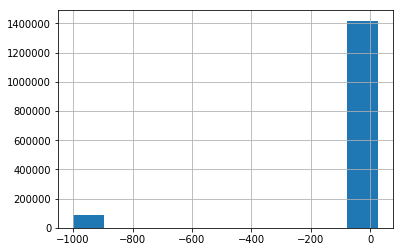

In [72]:
train['price'] = train['price'].apply(lambda x: np.log1p(x) if x != -999 else x)
train['price'].hist();

In [73]:
# sns.boxplot(train['price']); # Ящик с усами: середина это медиана, границы ящика это 0.25- и 0.75-квартили,усы - это полтора интеркваритильных размаха от медианы. То, что за усами - это выбросы 

In [74]:
# sns.countplot(train['region']);

In [75]:
# sns.countplot(train['category_name']);

In [76]:
# sns.countplot(train['user_type']);

In [77]:
# sns.countplot(train['city']);

In [78]:
# train['image_top_1'].hist();

In [79]:
null_value_stats = train.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Series([], dtype: int64)

## Change categorial features to numeric

In [80]:
list(map(lambda x: train.columns[x], np.where(train.dtypes != np.float)[0]))

['item_id',
 'user_id',
 'region',
 'city',
 'parent_category_name',
 'category_name',
 'param_1',
 'param_2',
 'param_3',
 'title',
 'description',
 'item_seq_number',
 'activation_date',
 'user_type',
 'image',
 'weekday',
 'is_weekend',
 'month',
 'day',
 'has_image',
 'has_description',
 'description_len',
 'title_len',
 'has_param_1',
 'has_param_2',
 'has_param_3',
 'has_price',
 'has_image_top_1']

In [81]:
categorical_features_indices = ['user_id','region','city','parent_category_name','category_name','param_1','param_2','param_3','item_seq_number','user_type','weekday','has_image']
categorical_features_indices

['user_id',
 'region',
 'city',
 'parent_category_name',
 'category_name',
 'param_1',
 'param_2',
 'param_3',
 'item_seq_number',
 'user_type',
 'weekday',
 'has_image']

In [82]:
le = LabelEncoder()

for feature in log_progress(categorical_features_indices, every=1):
    le.fit(train[feature].append(test[feature]))
    train[feature] = le.transform(train[feature])
    test[feature] = le.transform(test[feature])
    
le.classes_

array([0, 1])

In [83]:
train.head()

item_id  user_id  region  city  parent_category_name  category_name  \
0  b912c3c6a6ad   884270      19   462                     4             42   
1  2dac0150717d   227908      17  1314                     2             22   
2  ba83aefab5dc   576261      16  1290                     0              2   
3  02996f1dd2ea   755087      21   950                     4             42   
4  7c90be56d2ab   944363       4   318                     6              0   

   param_1  param_2  param_3                  title       ...        day  \
0      249        0        0  Кокоби(кокон для сна)       ...         28   
1      122        0        0      Стойка для Одежды       ...         26   
2       84        0        0         Philips bluray       ...         20   
3       38        0        0             Автокресло       ...         25   
4      278      124       47         ВАЗ 2110, 2003       ...         16   

   has_image  has_description description_len  title_len has_param_1  \
0          1                1              58         21           1   
1          1                1              41         17           1   
2          1                1              99         14           1   
3          1                1              22         10           1   
4          1                1              24         14           1   

   has_param_2  has_param_3  has_price  has_image_top_1  
0            0            0          1                1  
1            0            0          1                1  
2            0            0          1                1  
3            0            0          1                1  
4            1            1          1                1  

[5 rows x 31 columns]

In [84]:
test.head()

item_id  user_id  region  city  parent_category_name  category_name  \
0  6544e41a8817   867817       4   318                     4             10   
1  65b9484d670f   181851      19   993                     8              5   
2  8bab230b2ecd    45341      12   151                     0              2   
3  8e348601fefc   375979      18  1319                     2              4   
4  8bd2fe400b89   141497      14   243                     4             42   

   param_1  param_2  param_3              title       ...        day  \
0      110      198       75    Отдам бесплатно       ...         18   
1      119        0        0   Продам велосипед       ...         16   
2      318        0        0                BBK       ...         17   
3      108      131        0  Вытяжка Jetair 60       ...         17   
4      102        0        0  Коляска зима-лето       ...         15   

   has_image  has_description description_len  title_len has_param_1  \
0          1                1              12         15           1   
1          0                1              88         16           1   
2          1                1             132          3           1   
3          0                1              93         17           1   
4          1                1              60         17           1   

   has_param_2  has_param_3  has_price  has_image_top_1  
0            1            1          0                1  
1            0            0          1                0  
2            0            0          1                1  
3            1            0          1                0  
4            0            0          1                1  

[5 rows x 30 columns]

## Text features

In [85]:
import unicodedata as ud

latin_letters= {}

def is_latin(uchr):
    try: return latin_letters[uchr]
    except KeyError:
         return latin_letters.setdefault(uchr, 'LATIN' in ud.name(uchr))

def only_roman_chars(unistr):
    return all(is_latin(uchr)
           for uchr in unistr
           if uchr.isalpha()) # isalpha suggested by John Machin

In [86]:
import re

def no_number_preprocessor(tokens):
    # r = re.sub('(\d)+', 'NUM', tokens.lower())
    r = re.sub('(\d)+', '', tokens.lower())
    return r

analyzer = CountVectorizer(preprocessor=no_number_preprocessor).build_analyzer()
stemmer = SnowballStemmer("russian") 

import nltk
nltk.download('stopwords')

stopWords = stopwords.words('russian')
len(stopWords)

def stemming(doc):
    return (w if only_roman_chars(w) else stemmer.stem(w) for w in analyzer(doc))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/paperspace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [87]:
vectorizer = CountVectorizer(analyzer=stemming, stop_words=stopWords, max_features=100)
vectorizer.fit(train['title'].append(test['title']))

CountVectorizer(analyzer=<function stemming at 0x7f67905c86a8>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=100, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', '...гда', 'лучше', 'чуть', 'том', 'нельзя', 'такой', 'им', 'более', 'всегда', 'конечно', 'всю', 'между'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [88]:
len(vectorizer.get_feature_names())

100

In [89]:
vectorizer.get_feature_names()

['galaxy',
 'gb',
 'iphone',
 'lada',
 'samsung',
 'sony',
 'бел',
 'босоножк',
 'ботинк',
 'ботиночк',
 'брюк',
 'ваз',
 'велосипед',
 'весен',
 'весн',
 'ветровк',
 'вещ',
 'гараж',
 'год',
 'дач',
 'девочк',
 'демисезон',
 'детск',
 'джинс',
 'джинсов',
 'дива',
 'для',
 'дом',
 'женск',
 'зимн',
 'ижс',
 'из',
 'квартир',
 'кед',
 'кож',
 'кожан',
 'коляск',
 'комбинезон',
 'комнат',
 'комплект',
 'костюм',
 'кофт',
 'кресл',
 'крова',
 'кроватк',
 'кроссовк',
 'купл',
 'куртк',
 'лет',
 'летн',
 'м²',
 'мальчик',
 'машин',
 'мужск',
 'на',
 'набор',
 'натуральн',
 'нов',
 'ноутбук',
 'обув',
 'одежд',
 'осен',
 'от',
 'отд',
 'пальт',
 'плат',
 'плащ',
 'по',
 'под',
 'помещен',
 'прод',
 'прода',
 'работ',
 'размер',
 'резинов',
 'ремонт',
 'рубашк',
 'санда',
 'сапог',
 'сапожк',
 'свадебн',
 'см',
 'сним',
 'состоян',
 'сот',
 'спортивн',
 'стол',
 'сумк',
 'телевизор',
 'телефон',
 'туфл',
 'участк',
 'участок',
 'футболк',
 'час',
 'черн',
 'шапк',
 'шкаф',
 'эт',
 'юбк']

In [58]:
#vectorizer2 = CountVectorizer(analyzer=stemming, stop_words=stopWords)
#vectorizer2.fit(train['title'][:10].append(test['title'][:10]))
#vectorizer2.get_feature_names()

['some', 'punctuation']

In [90]:
from sklearn.externals import joblib
joblib.dump(vectorizer, 'titles_vect_100.pkl') 
# v = joblib.load('titles_vect_100.pkl')

['titles_vect_100.pkl']

In [91]:
train_title_vectorized_100 = vectorizer.transform(train['title'])

In [92]:
train_title_vectorized_100[:10]

<10x100 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [106]:
train_title_vect_dense = pd.SparseDataFrame(train_title_vectorized_100, columns=vectorizer.get_feature_names()).to_dense()


In [107]:
train_title_vect_dense.head()

galaxy  gb  iphone  lada  samsung  sony  бел  босоножк  ботинк  ботиночк  \
0     NaN NaN     NaN   NaN      NaN   NaN  NaN       NaN     NaN       NaN   
1     NaN NaN     NaN   NaN      NaN   NaN  NaN       NaN     NaN       NaN   
2     NaN NaN     NaN   NaN      NaN   NaN  NaN       NaN     NaN       NaN   
3     NaN NaN     NaN   NaN      NaN   NaN  NaN       NaN     NaN       NaN   
4     NaN NaN     NaN   NaN      NaN   NaN  NaN       NaN     NaN       NaN   

  ...   туфл  участк  участок  футболк  час  черн  шапк  шкаф  эт  юбк  
0 ...    NaN     NaN      NaN      NaN  NaN   NaN   NaN   NaN NaN  NaN  
1 ...    NaN     NaN      NaN      NaN  NaN   NaN   NaN   NaN NaN  NaN  
2 ...    NaN     NaN      NaN      NaN  NaN   NaN   NaN   NaN NaN  NaN  
3 ...    NaN     NaN      NaN      NaN  NaN   NaN   NaN   NaN NaN  NaN  
4 ...    NaN     NaN      NaN      NaN  NaN   NaN   NaN   NaN NaN  NaN  

[5 rows x 100 columns]

In [111]:
train_title_vect_dense.fillna(0, inplace=True)

In [112]:
train_title_vect_dense.to_csv('train_title_vect_100.csv', index=False)

In [113]:
train_title_vect = pd.read_csv('train_title_vect_100.csv')

In [114]:
train_title_vect.head()

galaxy   gb  iphone  lada  samsung  sony  бел  босоножк  ботинк  ботиночк  \
0     0.0  0.0     0.0   0.0      0.0   0.0  0.0       0.0     0.0       0.0   
1     0.0  0.0     0.0   0.0      0.0   0.0  0.0       0.0     0.0       0.0   
2     0.0  0.0     0.0   0.0      0.0   0.0  0.0       0.0     0.0       0.0   
3     0.0  0.0     0.0   0.0      0.0   0.0  0.0       0.0     0.0       0.0   
4     0.0  0.0     0.0   0.0      0.0   0.0  0.0       0.0     0.0       0.0   

  ...   туфл  участк  участок  футболк  час  черн  шапк  шкаф   эт  юбк  
0 ...    0.0     0.0      0.0      0.0  0.0   0.0   0.0   0.0  0.0  0.0  
1 ...    0.0     0.0      0.0      0.0  0.0   0.0   0.0   0.0  0.0  0.0  
2 ...    0.0     0.0      0.0      0.0  0.0   0.0   0.0   0.0  0.0  0.0  
3 ...    0.0     0.0      0.0      0.0  0.0   0.0   0.0   0.0  0.0  0.0  
4 ...    0.0     0.0      0.0      0.0  0.0   0.0   0.0   0.0  0.0  0.0  

[5 rows x 100 columns]

In [119]:
train.head()

item_id  user_id  region  city  parent_category_name  category_name  \
0  b912c3c6a6ad   884270      19   462                     4             42   
1  2dac0150717d   227908      17  1314                     2             22   
2  ba83aefab5dc   576261      16  1290                     0              2   
3  02996f1dd2ea   755087      21   950                     4             42   
4  7c90be56d2ab   944363       4   318                     6              0   

   param_1  param_2  param_3                  title       ...        day  \
0      249        0        0  Кокоби(кокон для сна)       ...         28   
1      122        0        0      Стойка для Одежды       ...         26   
2       84        0        0         Philips bluray       ...         20   
3       38        0        0             Автокресло       ...         25   
4      278      124       47         ВАЗ 2110, 2003       ...         16   

   has_image  has_description description_len  title_len has_param_1  \
0          1                1              58         21           1   
1          1                1              41         17           1   
2          1                1              99         14           1   
3          1                1              22         10           1   
4          1                1              24         14           1   

   has_param_2  has_param_3  has_price  has_image_top_1  
0            0            0          1                1  
1            0            0          1                1  
2            0            0          1                1  
3            0            0          1                1  
4            1            1          1                1  

[5 rows x 31 columns]

In [122]:
train_extended_title = pd.concat([train, train_title_vect], axis=1)

In [123]:
train_extended_title.head()

item_id  user_id  region  city  parent_category_name  category_name  \
0  b912c3c6a6ad   884270      19   462                     4             42   
1  2dac0150717d   227908      17  1314                     2             22   
2  ba83aefab5dc   576261      16  1290                     0              2   
3  02996f1dd2ea   755087      21   950                     4             42   
4  7c90be56d2ab   944363       4   318                     6              0   

   param_1  param_2  param_3                  title ...  туфл  участк  \
0      249        0        0  Кокоби(кокон для сна) ...   0.0     0.0   
1      122        0        0      Стойка для Одежды ...   0.0     0.0   
2       84        0        0         Philips bluray ...   0.0     0.0   
3       38        0        0             Автокресло ...   0.0     0.0   
4      278      124       47         ВАЗ 2110, 2003 ...   0.0     0.0   

   участок футболк  час черн  шапк  шкаф   эт  юбк  
0      0.0     0.0  0.0  0.0   0.0   0.0  0.0  0.0  
1      0.0     0.0  0.0  0.0   0.0   0.0  0.0  0.0  
2      0.0     0.0  0.0  0.0   0.0   0.0  0.0  0.0  
3      0.0     0.0  0.0  0.0   0.0   0.0  0.0  0.0  
4      0.0     0.0  0.0  0.0   0.0   0.0  0.0  0.0  

[5 rows x 131 columns]

In [137]:
X = train.drop(['image', 'activation_date', 'deal_probability', 'item_id', 'title', 'description'], axis=1)
y = train['deal_probability']
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

X_test = test.drop(['image', 'activation_date', 'item_id', 'title', 'description'], axis=1)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [138]:
X_train_matrix = X_train.as_matrix()
X_test_matrix = X_validation.as_matrix()

In [147]:
gbm = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7, silent=False, n_jobs=-1, nthread = 8, objective='reg:logistic', eval_metric='rmse', seed=42).fit(X_train_matrix, y_train)


In [148]:
gbm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0, learning_rate=0.08,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=8, objective='reg:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=False, subsample=0.75)

In [159]:
predictions = gbm.predict(X_train_matrix)

In [160]:
from sklearn.metrics import mean_squared_error

In [162]:
np.sqrt(mean_squared_error(y_train, predictions))

0.22950456962147026

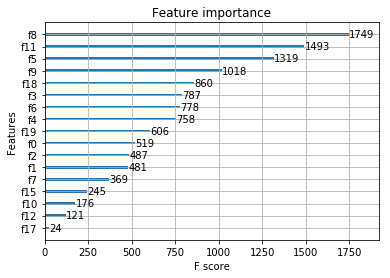

In [154]:
from xgboost import plot_importance
from matplotlib import pyplot

plot_importance(gbm)
pyplot.show()

In [157]:
X_train.columns

Index(['user_id', 'region', 'city', 'parent_category_name', 'category_name',
       'param_1', 'param_2', 'param_3', 'price', 'item_seq_number',
       'user_type', 'image_top_1', 'weekday', 'is_weekend', 'month', 'day',
       'has_image', 'has_description', 'description_len', 'title_len',
       'has_param_1', 'has_param_2', 'has_param_3', 'has_price',
       'has_image_top_1'],
      dtype='object')

In [ ]:
model.save_model('avito_catboost_model.dump')

In [ ]:
pred = model.predict(X_test, verbose=True)

In [ ]:
pred[:10]

In [ ]:
def normalize(x):
    return 0 if x < 0 else (1 if x > 1 else x)

pred2 = [normalize(x) for x in pred]

In [ ]:
pred2[:10]

In [ ]:
submission = pd.DataFrame(columns=['item_id', 'deal_probability'])

In [ ]:
submission['item_id'] = test['item_id']
submission['deal_probability'] = pred2

In [ ]:
submission.head()

In [ ]:
submission.to_csv('submission.csv', index=False)